# Keras U-Net starter - LB 0.277

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras import backend as K
import tensorflow.compat.v1.keras.backend as K

import tensorflow as tf

C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
from pathlib import Path

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

ROOT_DIR = Path('C:/Users/sinjy/jupyter_notebook/datasets')
DATA_DIR = ROOT_DIR / 'kaggle_datasets' / 'nuclei'
TRAIN_PATH = DATA_DIR / 'stage1_train'
TEST_PATH = DATA_DIR / 'stage2_test_final'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Get the data

### resize image

In [4]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ...')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH / id_
    img = imread(path / 'images' / (id_ + '.png'))[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path / 'masks'))[2]:
        mask_ = imread(path / 'masks' / mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),
                               axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ...


C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
  0%|                                                                                          | 0/670 [00:00<?, ?it/s]C:\Users\sinjy\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdoc

In [5]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ...')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH / id_
    try:
        img = imread(path / 'images' / (id_ + '.png'))[:, :, :IMG_CHANNELS]
    except:
        img = imread(path / 'images' / (id_ + '.png'))
        img = img / np.max(img) * 255
        img = np.tile(img[:, :, np.newaxis], (1, 1, 3))
        
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ...


100%|██████████████████████████████████████████████████████████████████████████████| 3019/3019 [01:23<00:00, 36.27it/s]

Done!


### check mask

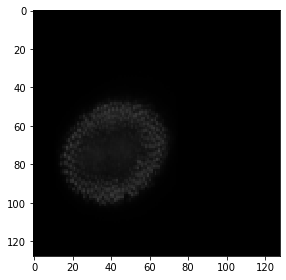

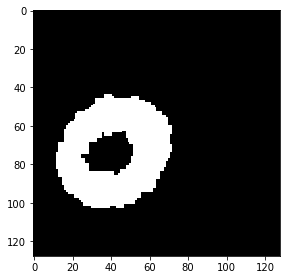

In [6]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Create our Keras metric

In [7]:
tf.config.run_functions_eagerly(True)
def mean_iou(y_true, y_pred):
    meaniou = tf.keras.metrics.MeanIoU(2)
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score = meaniou(y_true, y_pred_)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Build and train our neural network

### Build U-Net model

In [8]:
class DownConv(tf.keras.layers.Layer):
    def __init__(self, filters, pool):
        super(DownConv, self).__init__()
        self.pool = pool
        self.c1 = Conv2D(
            filters, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same')
        self.dropout = Dropout(0.2)
        self.c2 = Conv2D(
            filters, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same')
        if pool:
            self.pool = MaxPooling2D((2, 2))
    def call(self, x):
        x = self.c1(x)
        x = self.dropout(x)
        c = self.c2(x)
        if self.pool:
            p = self.pool(c)
            return c, p
        return c

class UpConv(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(UpConv, self).__init__()
        self.ct1 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), 
                                   padding='same')
        self.c1 = Conv2D(
            filters, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same')
        self.dropout = Dropout(0.2)
        self.c2 = Conv2D(
            filters, (3, 3), activation='elu', kernel_initializer='he_normal', 
            padding='same')
    def call(self, x, d):
        x = self.ct1(x)
        x = concatenate([x, d])
        x = self.c1(x)
        x = self.dropout(x)
        x = self.c2(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, filters_lst):
        super(Encoder, self).__init__()
        self.blocks = [DownConv(filters, True) for filters in filters_lst]
        self.conv = DownConv(256, False)
    def call(self, x):
        c_lst = []
        p = x
        for block in self.blocks:
            c, p = block(p)
            c_lst += [c]
        p = self.conv(p)
        return p, c_lst
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, filters_lst):
        super(Decoder, self).__init__()
        self.blocks = [UpConv(filters) for filters in filters_lst[::-1]]
        self.conv = Conv2D(1, (1, 1), activation='sigmoid')
    def call(self, p, c_lst):
        for block, c in zip(self.blocks, c_lst[::-1]):
            p = block(p, c)
        p = self.conv(p)
        return p
    
class UNet(tf.keras.Model):
    def __init__(self, filters_lst=[16, 32, 64, 128]):
        super(UNet, self).__init__()
        self.scaler = Lambda(lambda x: x / 255)
        self.encoder = Encoder(filters_lst)
        self.decoder = Decoder(filters_lst)
    def call(self, x):
        x = self.scaler(x)
        p, c_lst = self.encoder(x)
        y = self.decoder(p, c_lst)
        return y
    def summary(self):
        x = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS])
        model = tf.keras.Model(inputs=[x], outputs=self.call(x))
        return model.summary()

In [9]:
model = UNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
encoder (Encoder)               ((None, 8, 8, 256),  1178768     lambda[0][0]                     
__________________________________________________________________________________________________
decoder (Decoder)               (None, 128, 128, 1)  762337      encoder[0][0]                    
                                                                 encoder[0][1]                

In [10]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(
    'C:/Users/sinjy/jupyter_notebook/model/model-dsbow', verbose=1, 
    save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, 
                   epochs=50, callbacks=[earlystopper, checkpointer])

Epoch 1/50


C:\Users\sinjy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


38/38 [==============================] - 70s 2s/step - loss: 0.4428 - mean_iou: 0.5436 - val_loss: 0.4375 - val_mean_iou: 0.5979

Epoch 00001: val_loss improved from inf to 0.43752, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 2/50
38/38 [==============================] - 71s 2s/step - loss: 0.2319 - mean_iou: 0.7525 - val_loss: 0.3204 - val_mean_iou: 0.7453

Epoch 00002: val_loss improved from 0.43752 to 0.32037, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 3/50
38/38 [==============================] - 73s 2s/step - loss: 0.1799 - mean_iou: 0.8120 - val_loss: 0.3475 - val_mean_iou: 0.7840

Epoch 00003: val_loss did not improve from 0.32037
Epoch 4/50
38/38 [==============================] - 72s 2s/step - loss: 0.1524 - mean_iou: 0.8397 - val_loss: 0.1603 - val_mean_iou: 0.8312

Epoch 00004: val_loss improved from 0.32037 to 0.16034, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 5/50
38/38 [==============================] - 73s 2s/step - loss: 0.1419 - mean_iou: 0.8524 - val_loss: 0.1422 - val_mean_iou: 0.8411

Epoch 00005: val_loss improved from 0.16034 to 0.14222, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 6/50
38/38 [==============================] - 75s 2s/step - loss: 0.1299 - mean_iou: 0.8656 - val_loss: 0.1114 - val_mean_iou: 0.8784

Epoch 00006: val_loss improved from 0.14222 to 0.11144, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 7/50
38/38 [==============================] - 77s 2s/step - loss: 0.1244 - mean_iou: 0.8693 - val_loss: 0.1179 - val_mean_iou: 0.8652

Epoch 00007: val_loss did not improve from 0.11144
Epoch 8/50
38/38 [==============================] - 76s 2s/step - loss: 0.1190 - mean_iou: 0.8739 - val_loss: 0.1011 - val_mean_iou: 0.8940

Epoch 00008: val_loss improved from 0.11144 to 0.10106, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 9/50
38/38 [==============================] - 76s 2s/step - loss: 0.1145 - mean_iou: 0.8785 - val_loss: 0.0975 - val_mean_iou: 0.8973

Epoch 00009: val_loss improved from 0.10106 to 0.09754, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 10/50
38/38 [==============================] - 75s 2s/step - loss: 0.1107 - mean_iou: 0.8818 - val_loss: 0.0964 - val_mean_iou: 0.9012

Epoch 00010: val_loss improved from 0.09754 to 0.09644, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 11/50
38/38 [==============================] - 79s 2s/step - loss: 0.1069 - mean_iou: 0.8873 - val_loss: 0.1026 - val_mean_iou: 0.8841

Epoch 00011: val_loss did not improve from 0.09644
Epoch 12/50
38/38 [==============================] - 79s 2s/step - loss: 0.1100 - mean_iou: 0.8823 - val_loss: 0.1027 - val_mean_iou: 0.8929

Epoch 00012: val_loss did not improve from 0.09644
Epoch 13/50
38/38 [==============================] - 79s 2s/step - loss: 0.1065 - mean_iou: 0.8862 - val_loss: 0.0896 - val_mean_iou: 0.9047

Epoch 00013: val_loss improved from 0.09644 to 0.08965, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 14/50
38/38 [==============================] - 80s 2s/step - loss: 0.1038 - mean_iou: 0.8884 - val_loss: 0.1023 - val_mean_iou: 0.8909

Epoch 00014: val_loss did not improve from 0.08965
Epoch 15/50
38/38 [==============================] - 78s 2s/step - loss: 0.0998 - mean_iou: 0.8931 - val_loss: 0.0885 - val_mean_iou: 0.9089

Epoch 00015: val_loss improved from 0.08965 to 0.08852, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 16/50
38/38 [==============================] - 79s 2s/step - loss: 0.0975 - mean_iou: 0.8951 - val_loss: 0.1044 - val_mean_iou: 0.8899

Epoch 00016: val_loss did not improve from 0.08852
Epoch 17/50
38/38 [==============================] - 80s 2s/step - loss: 0.0989 - mean_iou: 0.8930 - val_loss: 0.0891 - val_mean_iou: 0.9099

Epoch 00017: val_loss did not improve from 0.08852
Epoch 18/50
38/38 [==============================] - 79s 2s/step - loss: 0.0959 - mean_iou: 0.8959 - val_loss: 0.0929 - val_mean_iou: 0.8989

Epoch 00018: val_loss did not improve from 0.08852
Epoch 19/50
38/38 [==============================] - 80s 2s/step - loss: 0.0949 - mean_iou: 0.8966 - val_loss: 0.0820 - val_mean_iou: 0.9130

Epoch 00019: val_loss improved from 0.08852 to 0.08203, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 20/50
38/38 [==============================] - 79s 2s/step - loss: 0.0924 - mean_iou: 0.8991 - val_loss: 0.0833 - val_mean_iou: 0.9106

Epoch 00020: val_loss did not improve from 0.08203
Epoch 21/50
38/38 [==============================] - 80s 2s/step - loss: 0.0906 - mean_iou: 0.9000 - val_loss: 0.0968 - val_mean_iou: 0.8954

Epoch 00021: val_loss did not improve from 0.08203
Epoch 22/50
38/38 [==============================] - 80s 2s/step - loss: 0.0893 - mean_iou: 0.9017 - val_loss: 0.0852 - val_mean_iou: 0.9106

Epoch 00022: val_loss did not improve from 0.08203
Epoch 23/50
38/38 [==============================] - 79s 2s/step - loss: 0.0886 - mean_iou: 0.9018 - val_loss: 0.0809 - val_mean_iou: 0.9115

Epoch 00023: val_loss improved from 0.08203 to 0.08095, saving model to C:/Users/sinjy/jupyter_notebook/model\model-dsbow


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


INFO:tensorflow:Assets written to: C:/Users/sinjy/jupyter_notebook/model\model-dsbow\assets


Epoch 24/50
38/38 [==============================] - 80s 2s/step - loss: 0.0891 - mean_iou: 0.9010 - val_loss: 0.0873 - val_mean_iou: 0.9162

Epoch 00024: val_loss did not improve from 0.08095
Epoch 25/50
38/38 [==============================] - 81s 2s/step - loss: 0.0887 - mean_iou: 0.9026 - val_loss: 0.0821 - val_mean_iou: 0.9144

Epoch 00025: val_loss did not improve from 0.08095
Epoch 26/50
38/38 [==============================] - 85s 2s/step - loss: 0.0866 - mean_iou: 0.9036 - val_loss: 0.0837 - val_mean_iou: 0.9129

Epoch 00026: val_loss did not improve from 0.08095
Epoch 27/50
38/38 [==============================] - 84s 2s/step - loss: 0.0854 - mean_iou: 0.9051 - val_loss: 0.0838 - val_mean_iou: 0.9142

Epoch 00027: val_loss did not improve from 0.08095
Epoch 28/50
38/38 [==============================] - 84s 2s/step - loss: 0.0823 - mean_iou: 0.9060 - val_loss: 0.0827 - val_mean_iou: 0.9131

Epoch 00028: val_loss did not improve from 0.08095
Epoch 00028: early stopping


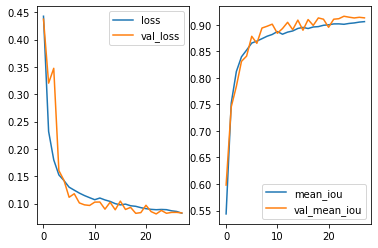

In [11]:
import matplotlib.pyplot as plt

x = range(len(results.history['loss']))
plt.subplot(121)
plt.plot(x, results.history['loss'], label='loss')
plt.plot(x, results.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(122)
plt.plot(x, results.history['mean_iou'], label='mean_iou')
plt.plot(x, results.history['val_mean_iou'], label='val_mean_iou')
plt.legend()

plt.show()

## Make predictions

In [12]:
model = load_model('C:/Users/sinjy/jupyter_notebook/model/model-dsbow', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(
        resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), 
               mode='constant', preserve_range=True))

C:\Users\sinjy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


95/95 [==============================] - 47s 492ms/step


### check train data

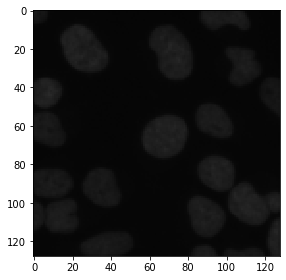

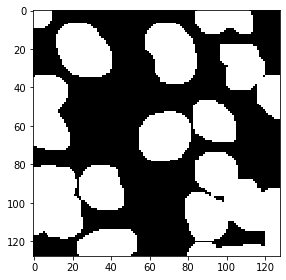

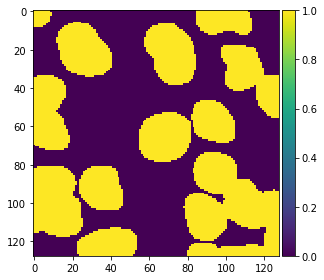

In [13]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

### check validation data

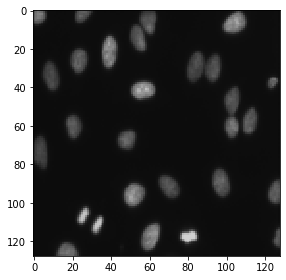

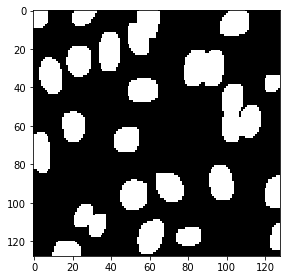

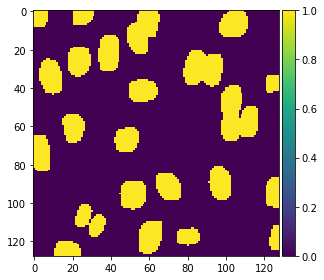

In [14]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

## Encode and submit our results

In [33]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [36]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = sum(list(prob_to_rles(preds_test_upsampled[n])), [])
    rles.append(rle)

In [37]:
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(ROOT_DIR / 'kaggle_predict' / 'sub-dsbow.csv', index=False)